In [59]:
#words = open('swedish_names.txt', 'r', encoding='utf-8').read().splitlines()
words = open('names.txt', 'r', encoding='utf-8').read().splitlines()
#words = [w.lower() for w in words if len(w) > 2] # Remove 2< longs words
#words = [w for w in words if w.isascii() and w.isalpha()] # Remove names with åäö or that contains bad things
#words = [w for w in words if '.' not in w]
print(words[-3:])
print(len(words))

['zyrie', 'zyron', 'zzyzx']
32033


In [60]:
letters = sorted(list(set(''.join(words)))) # Get all individual letters sorted, should be alphabet (if all letters are once included in our names)
num_of_unique_letters = len(letters) + 1 # Add 1 for '.' our special char
stoi = {s:i+1 for i,s in enumerate(letters)} # Create a mapping from a char to a int in order to index in tensor
stoi['.'] = 0 # Add . as a special char
itos = {i:s for s,i in stoi.items()} # Create the mapping in reverse
print(num_of_unique_letters)
print(letters)
itos

27
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [61]:
def build_data(words, nChars):
    x, y = [], []
    for w in words:
        chs = list('.'*nChars + w + ".")
        chs = [stoi[c] for c in chs]
        for i in range(len(chs)-nChars):
            x.append(chs[i:i+nChars])
            y.append(chs[i+nChars])
    return (x,y)

# Example 'zuzanna' becomes training example (.. -> z, ..z -> u, and so on until last nna -> .) and chars are converted to the ints

nChars = 3
print(words[-1:])
print(build_data(words[-1:], nChars))


['zzyzx']
([[0, 0, 0], [0, 0, 26], [0, 26, 26], [26, 26, 25], [26, 25, 26], [25, 26, 24]], [26, 26, 25, 26, 24, 0])


In [62]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'NVIDIA GeForce RTX 3070 Ti'

In [63]:
random.seed(3)
random.shuffle(words)
trainIdx = int(0.8*len(words))
valIdx = int(0.9*len(words))

xTrain, yTrain = build_data(words[0:trainIdx], nChars)
xTrain = torch.tensor(xTrain)
yTrain = torch.tensor(yTrain)

xVal, yVal = build_data(words[trainIdx:valIdx], nChars)
xVal = torch.tensor(xVal)
yVal = torch.tensor(yVal)

xTest, yTest = build_data(words[valIdx:], nChars)
xTest = torch.tensor(xTest)
yTest = torch.tensor(yTest)

In [74]:
g = torch.Generator().manual_seed(2147483647)

nC = 10 # Look up table, can also be seen as the first layer to our network
nHiddenN = 200 # Size of hidden layer

C = torch.randn((num_of_unique_letters, nC), generator=g)
W1 = torch.randn((nC * nChars, nHiddenN), generator=g) * ( (5/3) / (nC*nChars)**0.5 ) # kaiming init
b1 = torch.randn(nHiddenN, generator=g) * 0.01
W2 = torch.randn((nHiddenN, num_of_unique_letters), generator=g) * ( (5/3) / (nHiddenN)**0.5 ) # kaiming init
b2 = torch.randn(num_of_unique_letters, generator=g) * 0.01

parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))
trL = []
teL = []

11897


We could also add some search for the best hyper parameters but after testing a few different combinations it seems the architecture of the network is more important to improve on.

      0 / 200000: 4.0702
  10000 / 200000: 2.3945
  20000 / 200000: 2.5381
  30000 / 200000: 2.2073
  40000 / 200000: 1.7486
  50000 / 200000: 1.8151
  60000 / 200000: 2.4414
  70000 / 200000: 2.1104
  80000 / 200000: 2.2128
  90000 / 200000: 1.8763
 100000 / 200000: 1.6776
 110000 / 200000: 2.5204
 120000 / 200000: 1.8544
 130000 / 200000: 2.2378
 140000 / 200000: 2.3389
 150000 / 200000: 2.2057
 160000 / 200000: 2.3728
 170000 / 200000: 2.1800
 180000 / 200000: 2.1090
 190000 / 200000: 2.1134
Last tr loss: 2.0344629019386673


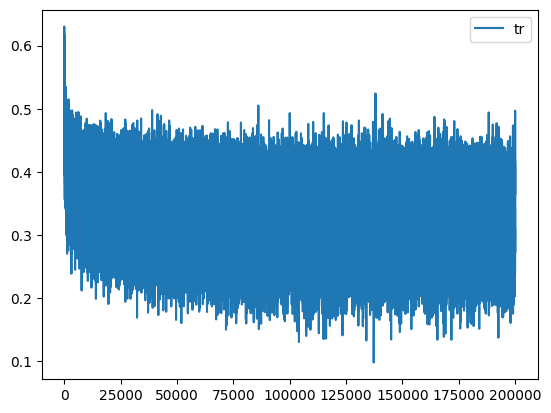

In [75]:
iters = 200000
lr = 0.1
batch_size = 32

for i in range(iters):
    # Get mini batch idx
    mIdx = torch.randint(0, xTrain.shape[0], (batch_size,))
    
    # Forward
    emb = C[xTrain[mIdx]]
    h = torch.tanh(emb.view(-1, nChars*nC) @ W1 + b1) # We use view to effiently "squash" the look up table's dimentions 
                                                      # in order to have them ass input to our network
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yTrain[mIdx])
    trL.append(loss.log10().item())
    
    # Backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.01 if i < 100000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d} /{iters:7d}: {loss.item():.4f}')
        
plt.plot([i for i in range(len(trL))], trL, label='tr')
plt.legend()
print(f'Last tr loss: {10**trL[-1]}')

In [77]:
# Calulate test loss
emb = C[xTest]
h = torch.tanh(emb.view(-1, nChars*nC) @ W1 + b1) # We use view to effiently "squash" the look up table's dimentions 
                                                  # in order to have them ass input to our network
logits = h @ W2 + b2
F.cross_entropy(logits, yTest).item()

2.142043352127075

Of course these losses cannot be directly compared to the previous work in the "Simple counts and NN.ipynb" but by looking at the names we produce can at least compare them without human interpretations.

In [79]:
for i in range(10):
    out = []
    context = [stoi[c] for c in list('.'*nChars)]
    while True:
        # Forward
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, nChars*nC) @ W1 + b1) # We use view to effiently "squash" the look up table's dimentions 
                                                          # in order to have them ass input to our network
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

cath.
cetre.
anaflenix.
keiana.
amaritt.
abie.
tivida.
thusha.
fyiharlin.
zeonta.


As we can see this method produces better names than our first attempt of both Simple counts and NN with only 1 nC and character encoding into more dimensions (instead of just numbers).

In [80]:
if nC == 2:
    # visualize dimensions 0 and 1 of the embedding matrix C for all characters
    plt.figure(figsize=(8,8))
    plt.scatter(C[:,0].data, C[:,1].data, s=200)
    print(itos)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    plt.grid('minor')
else:
    print("Cant visualize with more than 2 dims")

Cant visualize with more than 2 dims
